In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [3]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images("data_2"))
data = []
labels = []

[INFO] loading images...


In [4]:
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(IMG_HEIGHT, IMG_WIDTH))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [5]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [6]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=40,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.2,
	horizontal_flip=True,
	fill_mode="nearest")

In [7]:
model = tf.keras.models.Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.3), 
    Dense(256, activation='relu'),
    Dense(2, activation='softmax') # dense layer has a shape of 2 as we have only 2 classes 
])

In [8]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
# for layer in baseModel.layers:
# 	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [9]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
102/102 [==============================] - 163s 2s/step - loss: 0.5410 - accuracy: 0.7205 - val_loss: 0.2851 - val_accuracy: 0.8987
Epoch 2/20
102/102 [==============================] - 150s 1s/step - loss: 0.3729 - accuracy: 0.8410 - val_loss: 0.2149 - val_accuracy: 0.9316
Epoch 3/20
102/102 [==============================] - 152s 1s/step - loss: 0.3342 - accuracy: 0.8656 - val_loss: 0.2052 - val_accuracy: 0.9292
Epoch 4/20
102/102 [==============================] - 150s 1s/step - loss: 0.3080 - accuracy: 0.8867 - val_loss: 0.2152 - val_accuracy: 0.9194
Epoch 5/20
102/102 [==============================] - 117s 1s/step - loss: 0.2912 - accuracy: 0.8887 - val_loss: 0.1767 - val_accuracy: 0.9426
Epoch 6/20
102/102 [==============================] - 110s 1s/step - loss: 0.2912 - accuracy: 0.8824 - val_loss: 0.2160 - val_accuracy: 0.9267
Epoch 7/20
102/102 [==============================] - 111s 1s/step - loss: 0.3024 - accuracy: 0.8740 - val_loss: 0.169

In [10]:

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector_2.model", save_format="h5")


[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.95      0.98      0.97       433
without_mask       0.98      0.94      0.96       386

    accuracy                           0.96       819
   macro avg       0.96      0.96      0.96       819
weighted avg       0.96      0.96      0.96       819

[INFO] saving mask detector model...


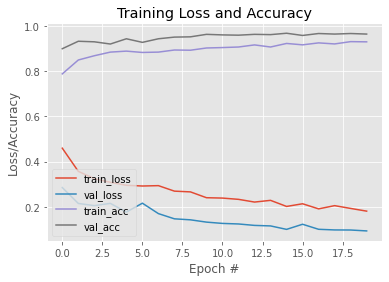

In [14]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("chart_2.png")